# Loop 1 Analysis: Understanding Current State and Path Forward

## Key Questions:
1. What is the per-N score breakdown? Which N values contribute most to the total?
2. Can we run tree_packer_v21 with more aggressive settings?
3. What's the gap between our score (70.73) and target (68.93)?

In [16]:
import pandas as pd
import numpy as np
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt

getcontext().prec = 30
scale_factor = Decimal('1e18')

# Load the current best submission
df = pd.read_csv('/home/code/experiments/001_baseline/submission.csv')
print(f'Loaded {len(df)} rows')
print(df.head(10))

Loaded 20100 rows
      id                    x                     y                   deg
0  001_0  s43.591192092102148  s-31.783267068741779   s44.999999999999979
1  002_0   s0.154097069621361   s-0.038540742694777  s203.629377730650162
2  002_1  s-0.154097069621359   s-0.561459257305227   s23.629377730649704
3  003_0   s1.131270585068746    s0.792202872326949  s113.563260441729483
4  003_1   s1.234055695842160    s1.275999500663759   s66.370622269343002
5  003_2   s0.641714640229075    s1.180458566613381  s155.134051937100821
6  004_0  s-0.324747789585767    s0.132109978100993  s156.370622143280201
7  004_1   s0.315354346193797    s0.132109978070379  s156.370622271937407
8  004_2   s0.324747789585715   s-0.732109978075982  s336.370622269343755
9  004_3  s-0.315354348186837   s-0.732109978101171  s336.370622143244020


In [17]:
# Define tree shape
class ChristmasTree:
    def __init__(self, center_x='0', center_y='0', angle='0'):
        self.center_x = Decimal(str(center_x))
        self.center_y = Decimal(str(center_y))
        self.angle = Decimal(str(angle))

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon([
            (float(Decimal('0.0') * scale_factor), float(tip_y * scale_factor)),
            (float(top_w / Decimal('2') * scale_factor), float(tier_1_y * scale_factor)),
            (float(top_w / Decimal('4') * scale_factor), float(tier_1_y * scale_factor)),
            (float(mid_w / Decimal('2') * scale_factor), float(tier_2_y * scale_factor)),
            (float(mid_w / Decimal('4') * scale_factor), float(tier_2_y * scale_factor)),
            (float(base_w / Decimal('2') * scale_factor), float(base_y * scale_factor)),
            (float(trunk_w / Decimal('2') * scale_factor), float(base_y * scale_factor)),
            (float(trunk_w / Decimal('2') * scale_factor), float(trunk_bottom_y * scale_factor)),
            (float(-(trunk_w / Decimal('2')) * scale_factor), float(trunk_bottom_y * scale_factor)),
            (float(-(trunk_w / Decimal('2')) * scale_factor), float(base_y * scale_factor)),
            (float(-(base_w / Decimal('2')) * scale_factor), float(base_y * scale_factor)),
            (float(-(mid_w / Decimal('4')) * scale_factor), float(tier_2_y * scale_factor)),
            (float(-(mid_w / Decimal('2')) * scale_factor), float(tier_2_y * scale_factor)),
            (float(-(top_w / Decimal('4')) * scale_factor), float(tier_1_y * scale_factor)),
            (float(-(top_w / Decimal('2')) * scale_factor), float(tier_1_y * scale_factor)),
        ])
        
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(
            rotated, 
            xoff=float(self.center_x * scale_factor), 
            yoff=float(self.center_y * scale_factor)
        )

print('ChristmasTree class defined')

ChristmasTree class defined


In [18]:
def load_configuration_from_df(n, df):
    """Loads all trees for a given N from the submission DataFrame."""
    group_data = df[df['id'].str.startswith(f'{n:03d}_')]
    trees = []
    for _, row in group_data.iterrows():
        x = str(row['x'])[1:] if str(row['x']).startswith('s') else str(row['x'])
        y = str(row['y'])[1:] if str(row['y']).startswith('s') else str(row['y'])
        deg = str(row['deg'])[1:] if str(row['deg']).startswith('s') else str(row['deg'])
        if x and y and deg:
            trees.append(ChristmasTree(x, y, deg))
    return trees

def get_score(trees, n):
    """Calculates the score (S^2 / N) for a given configuration."""
    if not trees:
        return 0.0
    xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T / float(scale_factor) for t in trees])
    min_x, min_y = xys.min(axis=0)
    max_x, max_y = xys.max(axis=0)
    side_length = max(max_x - min_x, max_y - min_y)
    return side_length**2 / n, side_length

print('Helper functions defined')

Helper functions defined


In [19]:
# Calculate per-N scores
per_n_scores = []
per_n_sides = []

for n in range(1, 201):
    trees = load_configuration_from_df(n, df)
    if trees:
        score, side = get_score(trees, n)
        per_n_scores.append({'n': n, 'score': score, 'side': side, 'trees': len(trees)})
        per_n_sides.append(side)
    else:
        per_n_scores.append({'n': n, 'score': 0, 'side': 0, 'trees': 0})
        per_n_sides.append(0)

scores_df = pd.DataFrame(per_n_scores)
total_score = scores_df['score'].sum()
print(f'Total score: {total_score:.10f}')
print(f'Target: 68.931058')
print(f'Gap: {total_score - 68.931058:.6f} ({(total_score - 68.931058) / 68.931058 * 100:.2f}%)')

Total score: 70.7343270130
Target: 68.931058
Gap: 1.803269 (2.62%)


In [20]:
# Identify worst-performing N values (highest score contribution)
scores_df_sorted = scores_df.sort_values('score', ascending=False)
print('Top 20 worst-performing N values (highest score contribution):')
print(scores_df_sorted.head(20).to_string())

print('\nTop 20 best-performing N values (lowest score contribution):')
print(scores_df_sorted.tail(20).to_string())

Top 20 worst-performing N values (highest score contribution):
     n     score      side  trees
0    1  0.661250  0.813173      1
1    2  0.450779  0.949504      2
2    3  0.434745  1.142031      3
4    5  0.416850  1.443692      5
3    4  0.416545  1.290806      4
6    7  0.399897  1.673104      7
5    6  0.399610  1.548438      6
8    9  0.387415  1.867280      9
7    8  0.385407  1.755921      8
14  15  0.379203  2.384962     15
9   10  0.376630  1.940696     10
20  21  0.376451  2.811667     21
19  20  0.376057  2.742469     20
10  11  0.375736  2.033002     11
21  22  0.375258  2.873270     22
15  16  0.374128  2.446640     16
25  26  0.373997  3.118320     26
11  12  0.372724  2.114873     12
12  13  0.372323  2.200046     13
24  25  0.372144  3.050182     25

Top 20 best-performing N values (lowest score contribution):
       n     score      side  trees
176  177  0.336330  7.715592    177
193  194  0.336320  8.077506    194
130  131  0.336298  6.637398    131
152  153  0.33628

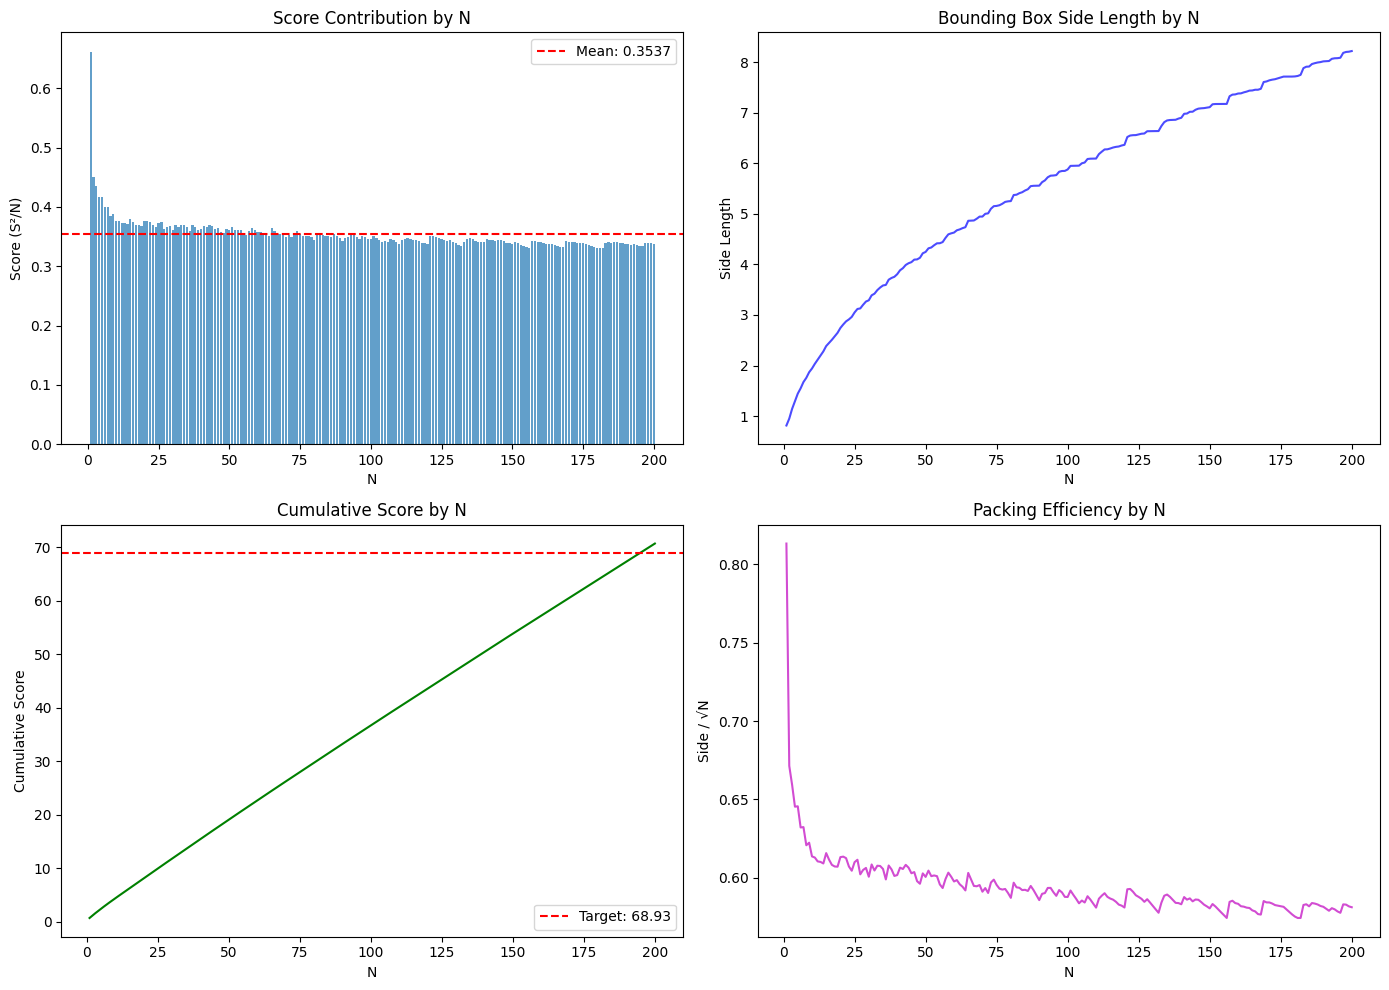

Saved analysis plot


In [21]:
# Plot score distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score per N
ax1 = axes[0, 0]
ax1.bar(scores_df['n'], scores_df['score'], alpha=0.7)
ax1.set_xlabel('N')
ax1.set_ylabel('Score (S²/N)')
ax1.set_title('Score Contribution by N')
ax1.axhline(y=scores_df['score'].mean(), color='r', linestyle='--', label=f'Mean: {scores_df["score"].mean():.4f}')
ax1.legend()

# Side length per N
ax2 = axes[0, 1]
ax2.plot(scores_df['n'], scores_df['side'], 'b-', alpha=0.7)
ax2.set_xlabel('N')
ax2.set_ylabel('Side Length')
ax2.set_title('Bounding Box Side Length by N')

# Cumulative score
ax3 = axes[1, 0]
scores_df['cumulative'] = scores_df['score'].cumsum()
ax3.plot(scores_df['n'], scores_df['cumulative'], 'g-')
ax3.axhline(y=68.931058, color='r', linestyle='--', label='Target: 68.93')
ax3.set_xlabel('N')
ax3.set_ylabel('Cumulative Score')
ax3.set_title('Cumulative Score by N')
ax3.legend()

# Efficiency (side / sqrt(N))
ax4 = axes[1, 1]
scores_df['efficiency'] = scores_df['side'] / np.sqrt(scores_df['n'])
ax4.plot(scores_df['n'], scores_df['efficiency'], 'm-', alpha=0.7)
ax4.set_xlabel('N')
ax4.set_ylabel('Side / √N')
ax4.set_title('Packing Efficiency by N')

plt.tight_layout()
plt.savefig('/home/code/exploration/per_n_analysis.png', dpi=100)
plt.show()
print('Saved analysis plot')

In [22]:
# Analyze where the biggest improvements could come from
print('\n=== IMPROVEMENT OPPORTUNITY ANALYSIS ===')
print(f'\nCurrent total: {total_score:.6f}')
print(f'Target: 68.931058')
print(f'Need to reduce by: {total_score - 68.931058:.6f}')

# If we could improve each N by X%, what would the total be?
for pct in [1, 2, 3, 5, 10]:
    improved = total_score * (1 - pct/100)
    print(f'  {pct}% improvement across all N: {improved:.6f} (gap: {improved - 68.931058:.6f})')

# Focus on high-score N values
print('\n=== TOP 10 N VALUES TO FOCUS ON ===')
top10 = scores_df_sorted.head(10)
print(f'These 10 N values contribute {top10["score"].sum():.4f} ({top10["score"].sum()/total_score*100:.1f}% of total)')
for _, row in top10.iterrows():
    n_val = int(row['n'])
    print(f'  N={n_val:3d}: score={row["score"]:.6f}, side={row["side"]:.6f}')


=== IMPROVEMENT OPPORTUNITY ANALYSIS ===

Current total: 70.734327
Target: 68.931058
Need to reduce by: 1.803269
  1% improvement across all N: 70.026984 (gap: 1.095926)
  2% improvement across all N: 69.319640 (gap: 0.388582)
  3% improvement across all N: 68.612297 (gap: -0.318761)
  5% improvement across all N: 67.197611 (gap: -1.733447)
  10% improvement across all N: 63.660894 (gap: -5.270164)

=== TOP 10 N VALUES TO FOCUS ON ===
These 10 N values contribute 4.3317 (6.1% of total)
  N=  1: score=0.661250, side=0.813173
  N=  2: score=0.450779, side=0.949504
  N=  3: score=0.434745, side=1.142031
  N=  5: score=0.416850, side=1.443692
  N=  4: score=0.416545, side=1.290806
  N=  7: score=0.399897, side=1.673104
  N=  6: score=0.399610, side=1.548438
  N=  9: score=0.387415, side=1.867280
  N=  8: score=0.385407, side=1.755921
  N= 15: score=0.379203, side=2.384962


In [23]:
# Check if tree_packer_v21 can be run with more aggressive settings\nimport subprocess\nimport os\n\nos.chdir('/home/code/experiments/001_baseline')\n\n# Check if tree_packer_v21 exists\nif os.path.exists('./tree_packer_v21'):\n    print('tree_packer_v21 exists, size:', os.path.getsize('./tree_packer_v21'), 'bytes')\n    print('This is the compiled C++ optimizer we can use')\nelse:\n    print('tree_packer_v21 not found')

In [24]:
# Check GLIBC version and bbox3 compatibility
print('System GLIBC version:')
!ldd --version | head -1

print('\nbbox3 requirements:')
!ldd ./bbox3 2>&1 | head -10

System GLIBC version:
ldd (Ubuntu GLIBC 2.31-0ubuntu9.17) 2.31



bbox3 requirements:
./bbox3: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by ./bbox3)
	linux-vdso.so.1 (0x00007ffc301ac000)
	libstdc++.so.6 => /lib/x86_64-linux-gnu/libstdc++.so.6 (0x0000741e6ac9e000)
	libm.so.6 => /lib/x86_64-linux-gnu/libm.so.6 (0x0000741e6ab4f000)
	libgomp.so.1 => /lib/x86_64-linux-gnu/libgomp.so.1 (0x0000741e6ab0d000)
	libgcc_s.so.1 => /lib/x86_64-linux-gnu/libgcc_s.so.1 (0x0000741e6aaf2000)
	libc.so.6 => /lib/x86_64-linux-gnu/libc.so.6 (0x0000741e6a900000)
	/lib64/ld-linux-x86-64.so.2 (0x0000741e6ae9f000)
	libdl.so.2 => /lib/x86_64-linux-gnu/libdl.so.2 (0x0000741e6a8f8000)
	libpthread.so.0 => /lib/x86_64-linux-gnu/libpthread.so.0 (0x0000741e6a8d5000)
